# CNN Guide
## By OPTIMUM
***
고객님 안녕하세요~ CNN을 활용한 딥러닝 모델링의 샘플 코드를 작성해보았습니다!

공부에 많은 도움이 되시길 바라며 궁금하신 점이 있다면 언제든 문의 주세요!

In [ ]:
from tensorflow.keras.datasets import cifar10

keras의 cifar10 데이터를 호출합니다. mnist와 마찬가지로 10개의 클래스를 가지는 데이터입니다.

In [56]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

train & test 데이터로 분리합니다.

In [4]:
print(f'X_train의 데이터 크기 {X_train.shape} / X_test의 데이터 크기 {X_test.shape}')
print(f'y_train의 데이터 크기 {y_train.shape} / y_test의 데이터 크기 {y_test.shape}')

X_train의 데이터 크기 (50000, 32, 32, 3) / X_test의 데이터 크기 (10000, 32, 32, 3)
y_train의 데이터 크기 (50000, 1) / y_test의 데이터 크기 (10000, 1)


train 데이터는 50,000개 / test 데이터는 10,000개 입니다.

1개의 데이터는 32 * 32 픽셀로 되어 있고 컬러 이미지 이므로 RGB채널을 뜻하는 3을 추가로 가집니다.(흑백의 경우는 1입니다.)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

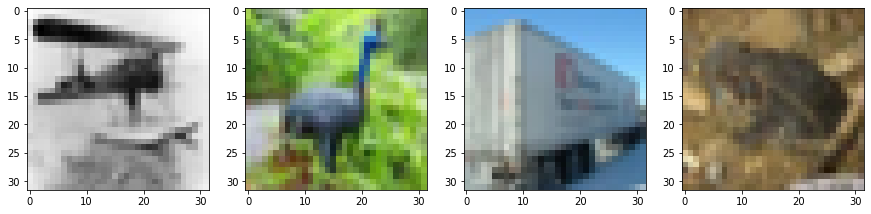

In [57]:
plt.figure(figsize = (15, 8))
plt.subplot(141)
plt.imshow(X_train[2021])
plt.subplot(142)
plt.imshow(X_train[6])
plt.subplot(143)
plt.imshow(X_train[15])
plt.subplot(144)
plt.imshow(X_train[23])
plt.grid(False)
plt.show()

4개의 샘플 데이터로 어떤 사진이 있는지 확인합니다. 비행기, 새, 트럭, 개구리가 있네요.

In [ ]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

데이터를 모두 실수형으로 변환합니다.

In [7]:
import numpy as np

데이터의 정규화를 수행합니다. 

In [8]:
mu = np.mean(X_train)
std = np.std(X_train)

In [9]:
rgb_mu = []
rgb_std = []

각 RGB 채널 별로 평균과 편차를 저장할 빈 리스트를 생성합니다.

In [10]:
for i in range(3) :
  m = np.mean(X_train[:, :, :, i])
  s = np.std(X_train[:, :, :, i])
  rgb_mu.append(m)
  rgb_std.append(s)

R, G, B 채널의 각 평균과 편차를 구합니다.

In [11]:
for i in range(3) :
  X_train[:, :, :, i] -= rgb_mu[i]
  X_train[:, :, :, i] /= rgb_std[i]
  X_test[:, :, :, i] -= rgb_mu[i]
  X_test[:, :, :, i] /= rgb_std[i]

train, test 데이터의 R, G, B 채널에 평균을 뺀 값을 편차로 나누어줍니다.

In [12]:
X_train.mean(), X_train.std()

(5.4744357195583385e-17, 0.9999999999999978)

평균과 편차가 매우 작아 정규화가 잘 된 것을 알 수 있습니다.

In [13]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 686kB 7.6MB/s 


이미지 분류를 위해 사용할 라이브러리와 메서드 입니다.

tensorflow_addons는 새로운 optimizer를 사용하기 위해 추가로 호출합니다.

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

10진 분류이기 때문에 원-핫 벡터 형태로 변환합니다.

In [30]:
model = Sequential()
model.add(Conv2D(64, 3, 3, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Conv2D(64, 3, 3, padding = 'same'))
model.add(Dropout(.2))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))

위와 같이 네트워크를 구성하였습니다.
- BatchNormalization : 출력값을 정규화합니다.

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 11, 11, 64)        1792      
_________________________________________________________________
batch_normalization_11 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
dropout_18 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)              

In [32]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 7, verbose = 1)
rl = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .75, patience = 7, verbose = 1, mode = 'max')
mc = ModelCheckpoint('optimum_CNN.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

keras는 callbacks라는 기능이 있는데 학습 과정 상황에 따라 학습을 종료하거나 학습 모델을 저장하고 학습률을 조정할 수 있습니다.
- EarlyStopping : 학습을 조기 종료하는 callback 기능으로 monitor에는 살펴볼 지표(train/val 데이터의 평가지표 혹은 loss)를 기준으로 mode(max or min)에 따라 patience만큼 더 지켜본 후 학습을 종료합니다.

예를 들어 위의 경우는 검증용 데이터의 정확도를 기준으로 7epochs 동안 val_accuaracy가 올라가지 않으면 학습을 종료합니다.

- ReduceLROnPlateau : 학습률을 조절하는 것으로 factor 비율 만큼 기존 학습률을 갱신합니다.

예를 들어 위의 경우는 val_accuracy를 기준으로 7epochs 동안 개선되지 않으면 기존 학습률을 75%수준으로 낮춥니다.

- ModelCheckpoint : 모델을 자동 저장하는 것으로 특정 조건이 만족될 때 마다 모델을 저장합니다.

예를 들어 위의 경우는 val_accuracy가 좋아질 때 마다 모델을 저장합니다.

In [33]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = tfa.optimizers.RectifiedAdam(0.0005))

원-핫 벡터형태이기 때문에 categorical_crossentropy를 loss로 사용합니다. optimizer는 tensorflow_addons의 RectifiedAdam을 사용합니다.

In [34]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 200, validation_split = .2, verbose = 1, shuffle = True, callbacks = [es, rl, mc])

Epoch 1/200
625/625 [==============================] - 6s 7ms/step - loss: 2.3301 - accuracy: 0.2237 - val_loss: 1.8142 - val_accuracy: 0.3491

Epoch 00001: val_accuracy improved from -inf to 0.34910, saving model to optimum_CNN.h5
Epoch 2/200
625/625 [==============================] - 4s 7ms/step - loss: 1.8422 - accuracy: 0.3387 - val_loss: 1.6751 - val_accuracy: 0.3984

Epoch 00002: val_accuracy improved from 0.34910 to 0.39840, saving model to optimum_CNN.h5
Epoch 3/200
625/625 [==============================] - 4s 7ms/step - loss: 1.6872 - accuracy: 0.3859 - val_loss: 1.5921 - val_accuracy: 0.4311

Epoch 00003: val_accuracy improved from 0.39840 to 0.43110, saving model to optimum_CNN.h5
Epoch 4/200
625/625 [==============================] - 4s 6ms/step - loss: 1.5806 - accuracy: 0.4248 - val_loss: 1.5171 - val_accuracy: 0.4633

Epoch 00004: val_accuracy improved from 0.43110 to 0.46330, saving model to optimum_CNN.h5
Epoch 5/200
625/625 [==============================] - 4s 6ms/s

데이터에서 64개의 데이터를 한 묶음(batch)으로 사용하여 데이터를 총 200번 학습시킵니다. validation_split은 인풋 데이터의 해당 비율만큼을 validation으로 사용하는 것입니다.

In [35]:
model = load_model('optimum_CNN.h5')

ModelCheckpoint에 따라서 저장된 모델을 불러옵니다.

In [37]:
from sklearn.metrics import accuracy_score

In [44]:
test_label = [np.argmax(x) for x in y_test]

원-핫 벡터이기 때문에 다시 원래 클래스로 변환합니다.
[0, 0, 0, 0, 1]이었다면 4를 반환합니다.

In [49]:
pred = [np.argmax(x) for x in model.predict(X_test)]

원-핫 벡터로 출력 되기 때문에 확률이 가장 높은 클래스를 저장합니다.

예를 들어 [0.1, 0.2, 0.4, 0.2, 0.1]의 출력 값을 얻었다면 위의 코드 실행시 2를 얻습니다.

In [55]:
print(f'해당 모델의 정확도는 {round(accuracy_score(test_label, pred), 4) * 100}%')

해당 모델의 정확도는 62.739999999999995%
